In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score

import torch
import torch.nn as nn

### 1. Data loading and data frame creation

The code in this section must be executed together, even if it is divided into different cells.

In [49]:
# read author id and h_index for training
df_train = pd.read_csv('../Data/train.csv', dtype={'author': np.int64,'h_index': np.float32})
df_test = pd.read_csv('../Data/test.csv', index_col=0, dtype={'author': np.int64})
n_train = df_train.shape[0]
n_test = df_test.shape[0]
print("n_train: {0}, n_test: {1}".format(n_train,n_test))

n_train: 174241, n_test: 43560


In [50]:
# read author embedding from graph nodes
dim_embeddings = 20
cols_embeddings = ["n_embedding_"+str(i) for i in range(dim_embeddings)]
dict_dtype = {'author_id':np.int64}
for i in range(dim_embeddings):
    dict_dtype['n_embeddings_'+str(i)] = np.float32
df_node_emb=pd.read_csv("../Data/node_embeddings_20.csv",sep=',',dtype=dict_dtype)

# read author embedding from abstracts
dim_embeddings = 64
cols_embeddings = ["at_embedding_"+str(i) for i in range(dim_embeddings)]
dict_dtype = {'author_id':np.int64}
for i in range(dim_embeddings):
    dict_dtype['at_embeddings_'+str(i)] = np.float32
df_author_emb=pd.read_csv("../Data/author_embeddings_64.csv",dtype=dict_dtype)


# version 1 of graph features
dict_dtype = {'author_id':np.int64,'core_number':np.float32,'clustering_coef':np.float32,
             'betweeness_coef':np.float32,'centrality':np.float32,'page_rank':np.float32,
              'clustering_coef_coauthorship':np.float32,'betweeness_coef_coauthorship':np.float32,
              'centrality_coauthorship':np.float32,'page_rank_coauthorship':np.float32}
df_graph_feat=pd.read_csv("../Data/graph_features.csv", dtype=dict_dtype)
'''
# version 2 of graph features
dict_dtype = {'author_id':np.int64,'core_number':np.float32,'clustering_coef':np.float32,
             'betweeness_coef':np.float32,'centrality':np.float32,'page_rank':np.float32,
              'clustering_coef_coauthorship':np.float32,'betweeness_coef_coauthorship':np.float32,
              'centrality_coauthorship':np.float32,'page_rank_coauthorship':np.float32,
              'degree':np.int32,'weighted_degree':np.float32,'onion_number':np.float32
              }
df_graph_feat=pd.read_csv("../Data/graph_features_v2.csv", dtype=dict_dtype)
'''

print("Loaded data.")

Loaded data.


In [51]:
# create the training dataframe.
df_train = df_train.merge(df_node_emb, left_on="author", right_on="author_id")
df_train = df_train.merge(df_author_emb, left_on="author", right_on="author_id")
df_train = df_train.merge(df_graph_feat, left_on="author", right_on="author_id")

X_id_train = df_train["author"].values
y_train = df_train["hindex"].values


features_to_drop = ["author","hindex","author_id_x","author_id_y",
                    "clustering_coef_coauthorship","betweeness_coef_coauthorship",
                    "centrality_coauthorship","page_rank_coauthorship","author_id"]
'''
features_to_drop = ["author","hindex","author_id_x","author_id_y",
                    "betweeness_coef_coauthorship",
                    "author_id"]
'''

df_train = df_train.drop(features_to_drop,axis=1)
X_train = df_train.values
print("Column names X_train: \n",df_train.columns.tolist())
print("Created X,y for training.")
print("Dimensions of X_train: ",X_train.shape)
print("Dimensions of y_train: ",y_train.shape)

# create the test dataframe. 
df_test = df_test.merge(df_node_emb, left_on="author", right_on="author_id")
df_test = df_test.merge(df_author_emb, left_on="author", right_on="author_id")
df_test = df_test.merge(df_graph_feat, left_on="author", right_on="author_id")

X_id_test = df_test["author"].values
y_test = df_test["hindex"].values

df_test = df_test.drop(features_to_drop,axis=1)
X_test = df_test.values
print("\nColumn names X_test: \n",df_test.columns.tolist())
print("Created X,y for testing.")
print("Dimensions of X_test: ",X_test.shape)
print("Dimensions of y_test: ",y_test.shape)

Column names X_train: 
 ['n_embedding_0', 'n_embedding_1', 'n_embedding_2', 'n_embedding_3', 'n_embedding_4', 'n_embedding_5', 'n_embedding_6', 'n_embedding_7', 'n_embedding_8', 'n_embedding_9', 'n_embedding_10', 'n_embedding_11', 'n_embedding_12', 'n_embedding_13', 'n_embedding_14', 'n_embedding_15', 'n_embedding_16', 'n_embedding_17', 'n_embedding_18', 'n_embedding_19', 'at_embedding_0', 'at_embedding_1', 'at_embedding_2', 'at_embedding_3', 'at_embedding_4', 'at_embedding_5', 'at_embedding_6', 'at_embedding_7', 'at_embedding_8', 'at_embedding_9', 'at_embedding_10', 'at_embedding_11', 'at_embedding_12', 'at_embedding_13', 'at_embedding_14', 'at_embedding_15', 'at_embedding_16', 'at_embedding_17', 'at_embedding_18', 'at_embedding_19', 'at_embedding_20', 'at_embedding_21', 'at_embedding_22', 'at_embedding_23', 'at_embedding_24', 'at_embedding_25', 'at_embedding_26', 'at_embedding_27', 'at_embedding_28', 'at_embedding_29', 'at_embedding_30', 'at_embedding_31', 'at_embedding_32', 'at_embe

In [139]:
## feed-forward neural network (ffnn)

def ffnn(X_train, y_train,metrics:list=['mean_squared_error'], 
                     transformation=None,transformation_inv=None,
                     val_size=0.25,seed=2,units_hidden_layers:list=[25,5],
                     activation_function=nn.LeakyReLU(0.1),loss_function=nn.MSELoss(),
                     learning_rate=0.01,dropout_rate=0.05,num_epochs=5000):
    '''
    X_train:training data with dependent variables. It can be a dataframe or a numpy matrix.
    y_train: training data with independent variable (h-index). It can be a dataframe or a numpy matrix.
    metrics: metrics to calculate the model performance. It is a list of strings. Only 'mse' and 'accuracy' supported.
    transformation: a function to apply to the partitions of y_train.
    transformation_inv: the inverse of transformation. It is applied to the predictions of the y_train partitions.
    val_size: proportion of the y_train to include y_val.
    seed: random number seed.
    units_hidden_layers: list of units in each hidden layer. Currently two hidden layers supported.
    activation_function: activation function to be used for the output of all the hidden layers.
    dropout_rate: droptout rate. It turn off some neurons randomly.
    num_epochs: number of epochs in the training phase.
    '''
    
    y_train = y_train.reshape(-1,1)
    
    

    # split training data for validation purposes
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=seed) 
    
    # save a copy of the data
    X_tr_orig = np.copy(X_tr)
    X_val_orig = np.copy(X_val)
    y_tr_orig = np.copy(y_tr)
    y_val_orig = np.copy(y_val)
    
    # standardize features by removing the mean and scaling to unit variance
    
    scaler_x = StandardScaler()
    scaler_x.fit(X_tr)
    X_tr = scaler_x.transform(X_tr)
    X_val = scaler_x.transform(X_val)
    
    scaler_y = StandardScaler()
    scaler_y.fit(y_train)
    y_tr = scaler_y.transform(y_tr)
    y_val = scaler_y.transform(y_val)
    
    if(transformation is not None):
        try:
            y_tr = transformation(y_tr)
            y_val = transformation(y_val)
        except:
            pass
    
    # speed the computations using a GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # convert the data from Numpy arrays to Tensors
    X_tr = torch.from_numpy(X_tr).float().to(device)
    X_val = torch.from_numpy(X_val).float().to(device)
    y_tr = torch.from_numpy(y_tr).float().to(device)
    y_val = torch.from_numpy(y_val).float().to(device)
    
    # create the model and send it to the fastest available device
    model = nn.Sequential(
    nn.Linear(X_train.shape[1], units_hidden_layers[0], bias=True),
    activation_function,
    nn.Dropout(dropout_rate),
    nn.Linear(units_hidden_layers[0], units_hidden_layers[1], bias=True),
    activation_function,
    nn.Linear(units_hidden_layers[1], 1, bias=True),
    nn.ReLU()
    )
    model.to(device)
    
    # initialize weights randomly
    def init_weights(mod):
        if isinstance(mod, nn.Linear):
            nn.init.xavier_uniform_(mod.weight)
            mod.bias.data.fill_(0.01)
    
    model.apply(init_weights)
    
    # choose the loss function and the optimizer
    loss_function = loss_function
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # init performance measures
    list_losses_tr = []
    list_losses_val = []
    list_accuracy_tr = []
    list_accuracy_val = []
    
    for epoch in range(num_epochs):
        y_pred_tr=model.forward(X_tr)
        loss_tr = loss_function(y_pred_tr, y_tr)
        optimizer.zero_grad() # required since pytorch accumulates the gradients
        loss_tr.backward() # backpropagation step
        optimizer.step() # update the parameters
            
        # update loss and accuracy on train and test
        y_pred_val=model.forward(X_val)
        loss_val = loss_function(y_pred_val, y_val)
        
        with torch.no_grad():
            if('mean_squared_error' in metrics):
                list_losses_tr.append(loss_tr.data)
                list_losses_val.append(loss_val.data)
            if('accuracy' in metrics):
                list_accuracy_tr.append(accuracy_score(y_tr.cpu(), y_pred_tr.cpu()))
                list_accuracy_val.append(accuracy_score(y_val.cpu(), y_pred_val.cpu()))
        
        # print results from time to time (fixed frequency)
        if(epoch % int(num_epochs/5) == 0):
            print('Epoch: {0},\tLoss train: {1},\tLoss val: {2}'.format(epoch,round(loss_tr.cpu().data.item(),5),round(loss_val.cpu().data.item(),5)))
        
    
    with torch.no_grad():
    
        if(transformation_inv is not None):
            try:
                y_pred_tr = transformation_inv(y_pred_tr.cpu())
                y_pred_val = transformation_inv(y_pred_val.cpu())
            except:
                pass
        config = "learning_rate: "+str(learning_rate)+", val_size: "+str(val_size)
        config += ", dropout_rate: "+str(dropout_rate)+", activation_function: "
        config += str(activation_function)+", units_hidden_layers: "+str(units_hidden_layers)
        
        mse_tr = -1
        mse_val = -1
        
        print("\nConfig:",config)
        if('mean_squared_error' in metrics):
            mse_tr = mean_squared_error(y_tr_orig,scaler_y.inverse_transform(y_pred_tr.cpu()))
            mse_val = mean_squared_error(y_val_orig,scaler_y.inverse_transform(y_pred_val.cpu()))
            print("FFNN mean_squared_error on train:",mse_tr)
            print("FFNN mean_squared_error on test:",mse_val)
        if('accuracy' in metrics):
            print("FFNN accuracy on train:",accuracy_score(y_tr.cpu(), y_pred_tr.cpu()))
            print("FFNN accuracy on test with:",accuracy_score(y_val.cpu(), y_pred_val.cpu()))
        
        null_vect = torch.Tensor(np.zeros((1,len(X_tr[0])))).float().to(device)
        print("Prediction of null features: ",model.forward(null_vect).cpu()[0][0])
    
    return model,list_losses_tr,list_losses_val,config,mse_tr,mse_val

In [ ]:
learning_rate = [1,1e-1,1e-2]
val_size = [0.2,0.25]
dropout_rate = [0.1,0.2]
activation_function = [nn.LeakyReLU(0.1),nn.ReLU(),nn.Tanh()]
units_hidden_layers=[[25,5],[20,4]]

list_config = []
list_mse_tr = []
list_mse_val = []


for l_r in learning_rate:
    for v_s in val_size:
        for d_r in dropout_rate:
            for a_f in activation_function:
                for uhl in units_hidden_layers:   
                    _,mse_tr,mse_val,config,_,_ = ffnn(X_train,y_train,val_size=v_s,learning_rate=l_r,
                                                   dropout_rate=d_r,activation_function=a_f,
                                                   units_hidden_layers=uhl)
                    list_config.append(config)
                    list_mse_tr.append(mse_tr[len(mse_tr)-1])
                    list_mse_val.append(mse_tr[len(mse_val)-1])

#ffnn(X_train, y_train, transformation=np.log10,transformation_inv=lambda array: np.power(10,array))

In [143]:
model,list_losses_tr,list_losses_val,_,_,_ = ffnn(X_train,y_train,val_size=0.25,learning_rate=1e-1,
                                                   dropout_rate=0.0,activation_function=nn.LeakyReLU(0.1),
                                                   units_hidden_layers=[20,4],num_epochs=10000)

Epoch: 0,	Loss train: 1.28546,	Loss val: 0.79199
Epoch: 2000,	Loss train: 0.45862,	Loss val: 0.53726
Epoch: 4000,	Loss train: 0.45729,	Loss val: 0.54501
Epoch: 6000,	Loss train: 0.45542,	Loss val: 0.54092
Epoch: 8000,	Loss train: 0.45557,	Loss val: 0.54233

Config: learning_rate: 0.1, val_size: 0.25, dropout_rate: 0.0, activation_function: LeakyReLU(negative_slope=0.1), units_hidden_layers: [20, 4]
FFNN mean_squared_error on train: 72.59621406173262
FFNN mean_squared_error on test: 86.35323041684082
Prediction of null features:  tensor(2.2566)


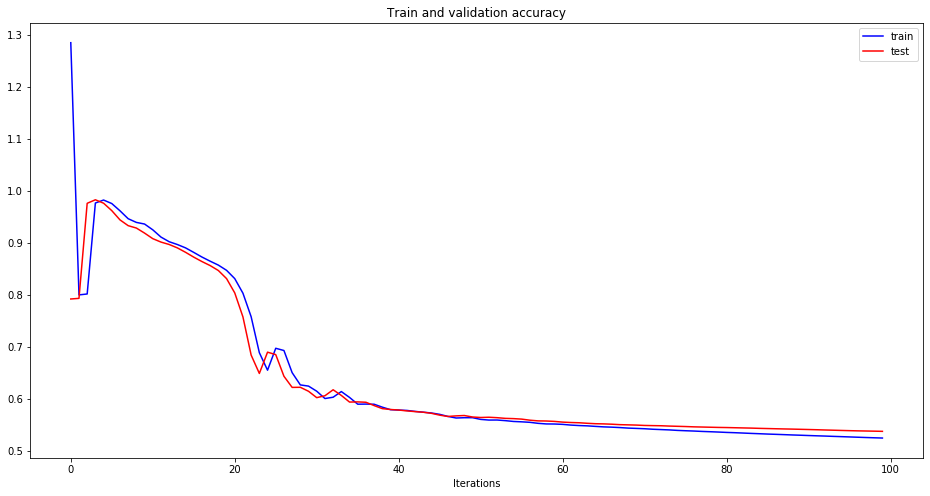

In [144]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16,8))
ax1.plot([loss.cpu() for loss in list_losses_tr][:100], c='b', label='train')
ax1.plot([loss.cpu() for loss in list_losses_val][:100], c='r', label='test')
ax1.set_title("Train and validation accuracy")
ax1.set_xlabel("Iterations")
plt.legend()
plt.show()